In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.5,), (0.5,))
                               ])

In [3]:
# Load data
trainset = datasets.MNIST('./mnist/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('./mnist/test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


label  tensor(0)


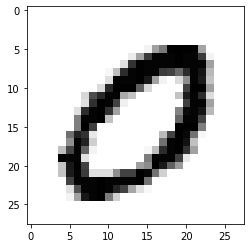

In [5]:
# Show images
import random

k = random.randrange(63)
plt.imshow(images[k].numpy().squeeze(), cmap='gray_r');
print('label ', labels[k])

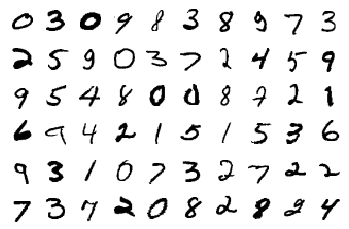

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r');

In [7]:
# Neural network model
import torch.nn.functional as F

class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 9, 3)
        self.fc1 = nn.Linear(9*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_size(x.size()))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    
    def num_size(self, size):
        num = size[1]*size[2]*size[3]
        return num
    
net = NetCNN()
print(net)

NetCNN(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=225, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
# Define loss function
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
# Train data
time0 = time()
epochs = 15
track_loss1 = []
track_loss2 = []
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for images, labels in trainloader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    else:
        track_loss1.append(running_loss)
        track_loss2.append(running_loss/len(trainloader))
        print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(trainloader)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.05744442757792961
Epoch 1 - Training loss: 0.05485966692054108
Epoch 2 - Training loss: 0.0526269418512608
Epoch 3 - Training loss: 0.050160568722559494
Epoch 4 - Training loss: 0.047862123972279576
Epoch 5 - Training loss: 0.04568746110172704
Epoch 6 - Training loss: 0.045004960606251955
Epoch 7 - Training loss: 0.04266378473674656
Epoch 8 - Training loss: 0.04061924765553715
Epoch 9 - Training loss: 0.03985358346022789
Epoch 10 - Training loss: 0.03772760377819541
Epoch 11 - Training loss: 0.037265148853435355
Epoch 12 - Training loss: 0.03522033281343828
Epoch 13 - Training loss: 0.03372665699623497
Epoch 14 - Training loss: 0.03269164911448968

Training Time (in minutes) = 6.660377987225851


Predicted Digit = 9
tensor(9)


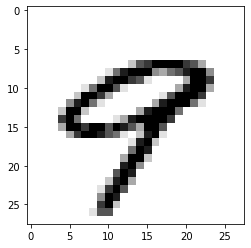

In [17]:
images, labels = next(iter(valloader))

img = images
with torch.no_grad():
    logps = net(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
plt.imshow(img[0].numpy().squeeze(), cmap='gray_r');
print(labels[0])

In [18]:
# Test Image
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(-1, 1, 28, 28)
    with torch.no_grad():
        logps = net(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9849


In [38]:
# Save model
torch.save(net.state_dict(), './mnist/my_model.pt') 


In [39]:
model = NetCNN()
model.load_state_dict(torch.load('./mnist/my_model.pt'))
model.eval()


NetCNN(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=225, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [32]:
torch.save(net, './mnist/my_model2.pt') 

In [34]:
model = torch.load('./mnist/my_model2.pt')

Predicted Digit = 5
tensor(5)


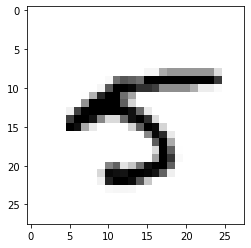

In [37]:
images, labels = next(iter(valloader))

img = images
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
plt.imshow(img[0].numpy().squeeze(), cmap='gray_r');
print(labels[0])

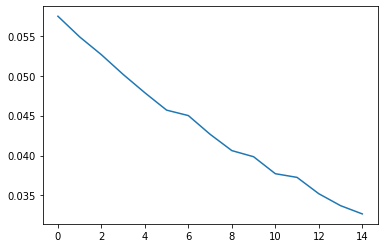

In [24]:
# Plot
# plt.plot(range(len(track_loss1)), track_loss1)
plt.plot(range(len(track_loss2)), track_loss2)
plt.show()